In [1]:
NOTE = 'Decision-function/Predict-probaの取得'
notebook_name = '087'
CV = 'GroupK-Fold(pitcherID)'
group_col = 'pitcherID'

In [2]:
import json
import os
import os.path
import pickle
import sys

import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import RidgeClassifier, LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import ComplementNB, GaussianNB
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
import matplotlib.pyplot as plt
import seaborn as sns

SCRIPT_PATH = os.path.join('..', 'scripts')
if SCRIPT_PATH not in sys.path:
    sys.path.append(SCRIPT_PATH)
from features import CATEGORICAL_FEATURES, VECTOR_FEATURES

In [3]:
OUTPUT_DIR = os.path.basename(notebook_name)
SUB_FILENAME = notebook_name[:3] + '_submission.csv'
assert(SUB_FILENAME not in pd.read_csv('submissions.csv').filename.tolist())
print(SUB_FILENAME, OUTPUT_DIR)
if not os.path.isdir(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

SEED = 1

# class_weights for CatBoostClassifier, copied from 020
CLASS_WEIGHTS = {
        0: 0.33822833,
        1: 0.4574968, 
        2: 0.71590909,
        3: 1.00280899,
        4: 3.17333333,
        5: 11.45454545,
        6: 194.72727273,
        7: 17.85
    }

087_submission.csv 087


In [4]:
train = pd.read_csv(os.path.join('001_EDA', 'train_data_preprocessed.csv'))
test = pd.read_csv(os.path.join('001_EDA', 'test_data_preprocessed.csv'))

In [5]:
groups = train[group_col]

In [6]:
# Minimal features
minimal_features = [
    'inningNo',
    'totalPitchingCount',
    'B',
    'S',
    'O',
    'b1',
    'b2',
    'b3',
    'numRunners',
    'batterID',
    'pitcherID',
    'Match',
    'isBatterHandLeft',
    'isPitcherHandLeft',
    'isBatterPitcher',
    'isBottom',
    'batterTeam',
    'pitcherTeam',
]

# categorical_features = [f for f in minimal_features if f in CATEGORICAL_FEATURES]
# discrete_features = list(set(minimal_features) - set(categorical_features))
# print(categorical_features)
# print(discrete_features)

# Execute if categories should be one-hot style
## categorical features
# for c in CATEGORICAL_FEATURES:
#     assert(train[c].isin(test[c]).sum() == train.shape[0])
#     assert(test[c].isin(train[c]).sum() == test.shape[0])
# train = pd.get_dummies(train, columns=CATEGORICAL_FEATURES, drop_first=True)
# test = pd.get_dummies(test, columns=CATEGORICAL_FEATURES, drop_first=True)
# assert(set(train.columns.tolist()) - set(test.columns.tolist()) == {'y'})
# assert(set(test.columns.tolist()) - set(train.columns.tolist()) == set())
# categorical_features = []
# for c in CATEGORICAL_FEATURES:
#     categorical_features += [c_ for c_ in train.columns if c_.startswith(f'{c}_')]
categorical_features = CATEGORICAL_FEATURES
## vector features
vector_features = VECTOR_FEATURES
## discrete features
discrete_features = [c for c in train.columns
                     if c not in ['y', 'id'] + vector_features + categorical_features]
## all features
features = categorical_features + discrete_features + vector_features

len(categorical_features), len(vector_features), len(discrete_features)

(12, 384, 107)

In [7]:
categorical_features

['batterID',
 'pitcherID',
 'Match',
 'isBatterHandLeft',
 'isPitcherHandLeft',
 'isBatterPitcher',
 'isBottom',
 'batterTeam',
 'pitcherTeam',
 'b1',
 'b2',
 'b3']

In [8]:
discrete_features

['totalPitchingCount',
 'B',
 'S',
 'O',
 'inningNo',
 'numRunners',
 'pitcherHoursElapsed',
 'pitcherNumGamesParticipated',
 'batterHoursElapsed',
 'batterNumGamesParticipated',
 'speedcount',
 'speedmean',
 'speedstd',
 'speedmin',
 'speed25%',
 'speed50%',
 'speed75%',
 'speedmax',
 'speedrange',
 'speedmeanDiff',
 'speedstdDiff',
 'speedminDiff',
 'speed25%Diff',
 'speed50%Diff',
 'speed75%Diff',
 'speedmaxDiff',
 'pitchTypeRatioカットファストボール',
 'pitchTypeRatioカーブ',
 'pitchTypeRatioシュート',
 'pitchTypeRatioシンカー',
 'pitchTypeRatioストレート',
 'pitchTypeRatioスライダー',
 'pitchTypeRatioチェンジアップ',
 'pitchTypeRatioフォーク',
 'battersFaced',
 'gameIDCount',
 'numInningsSum',
 'inningFromMin',
 'inningFromMean',
 'inningFromMedian',
 'inningFromMax',
 'inningFromStd',
 'inningToMin',
 'inningToMean',
 'inningToMedian',
 'inningToMax',
 'inningToStd',
 'pitcherNumStrikeOuts',
 'pitcherNumWalks',
 'hitsAllowed',
 'K/9',
 'BB/9',
 'K1p/BB1p',
 'whips',
 'pitchersFaced',
 'batterNumStrikeOuts',
 'batterNumWa

In [9]:
vector_features

['ballPositionLabel__no_data__',
 'ど真ん中',
 '内角中心',
 '内角低め',
 '内角高め',
 '外角中心',
 '外角低め',
 '外角高め',
 '真ん中低め',
 '真ん中高め',
 'ballPositionLabeld1',
 'ballPositionLabeld2',
 'ballPositionLabeld3',
 'ballPositionLabeld4',
 'ballPositionLabeld5',
 'ballPositionLabeld6',
 'ballPositionLabeld7',
 'ballPositionLabeld8',
 'ballPositionLabeld9',
 'ballPositionLabeld10',
 'ballPositionLabeld11',
 'ballPositionLabeld12',
 'ballPositionLabeld13',
 'ballPositionLabeld14',
 'ballPositionLabeld15',
 'ballPositionLabeld16',
 'ballPositionLabeld17',
 'ballPositionLabeld18',
 'ballPositionLabeld19',
 'ballPositionLabeld20',
 'ballPositionLabeld21',
 'ballPositionLabeld22',
 'ballPositionLabeld23',
 'ballPositionLabeld24',
 'ballPositionLabeld25',
 'ballPositionLabeld26',
 'ballPositionLabeld27',
 'ballPositionLabeld28',
 'ballPositionLabeld29',
 'ballPositionLabeld30',
 'ballPositionLabeld31',
 'ballPositionLabeld32',
 'ballPositionLabeld33',
 'ballPositionLabeld34',
 'ballPositionLabeld35',
 'ballPositionLabe

In [10]:
# features = [c for c in train.columns if c not in ('id', 'y')]
# assert(set(features) - set(test.columns.tolist()) == set())

In [11]:
# discrete_features = [f for f in features if f not in categorical_features]
# discrete_features

In [12]:
with open(os.path.join('001_EDA', f'group_kfold_{group_col}.json'), 'r') as f:
    fold = json.load(f)
fold

{'0': [120,
  478,
  504,
  607,
  587,
  107,
  136,
  447,
  363,
  2,
  618,
  593,
  616,
  597,
  407,
  48,
  58,
  4,
  394,
  49],
 '1': [311,
  305,
  269,
  143,
  224,
  182,
  267,
  55,
  156,
  550,
  371,
  336,
  575,
  158,
  400,
  211,
  647,
  222,
  493,
  528],
 '2': [130,
  651,
  298,
  448,
  387,
  405,
  634,
  438,
  102,
  245,
  507,
  190,
  147,
  520,
  169,
  210,
  409,
  595,
  494,
  630],
 '3': [247,
  128,
  282,
  185,
  657,
  288,
  459,
  45,
  419,
  16,
  434,
  579,
  596,
  435,
  81,
  334,
  181,
  6,
  467,
  635],
 '4': [348,
  373,
  191,
  101,
  116,
  59,
  383,
  517,
  506,
  350,
  376,
  460,
  35,
  97,
  650,
  119,
  662,
  10,
  359],
 '5': [542,
  241,
  155,
  218,
  196,
  82,
  532,
  524,
  31,
  294,
  110,
  578,
  137,
  476,
  358,
  552,
  262,
  553],
 '6': [483,
  519,
  377,
  395,
  481,
  -1,
  146,
  563,
  29,
  25,
  539,
  114,
  522,
  501,
  474,
  440,
  351,
  275],
 '7': [629,
  365,
  640,
  623,
  

In [13]:
def train_evaluate_predict(X_train: pd.DataFrame,
                           X_valid: pd.DataFrame,
                           X_test: pd.DataFrame,
                           y_train: np.ndarray,
                           y_valid: np.ndarray,
                           clf,
                           fit_params: dict = None) -> tuple:
    if fit_params is None:
        clf = clf.fit(X_train, y_train)
    else:
        clf = clf.fit(X_train, y_train, **fit_params)
    pred_train = clf.predict(X_train)
    print(f'train score: {f1_score(y_train, pred_train, average="macro"):.5f}')
    pred_valid = clf.predict(X_valid)
    print(f'valid score: {f1_score(y_valid, pred_valid, average="macro"):.5f}')
    if hasattr(clf, 'predict_proba'):
        proba_train = pd.DataFrame(data=clf.predict_proba(X_train), columns=clf.classes_)
        proba_valid = pd.DataFrame(data=clf.predict_proba(X_valid), columns=clf.classes_)
        proba_test = pd.DataFrame(data=clf.predict_proba(X_test), columns=clf.classes_)
    else:
        proba_train = pd.DataFrame(data=clf.decision_function(X_train), columns=clf.classes_)
        proba_valid = pd.DataFrame(data=clf.decision_function(X_valid), columns=clf.classes_)
        proba_test = pd.DataFrame(data=clf.decision_function(X_test), columns=clf.classes_)
    return clf, proba_train, proba_valid, proba_test

In [14]:
%%time
# splitter = StratifiedKFold(shuffle=True, random_state=SEED, n_splits=N)
cv_pred_dfs = []
pred_dfs = []
metrics = {'train': [], 'valid': []}
models = []
# for i, (train_idx, valid_idx) in enumerate(splitter.split(train, train.y)):
for str_i, ids in fold.items():
    i = int(str_i)
    mask = groups.isin(ids)  # training/validation = False/True
    train_idx, id_train, X_train, y_train, valid_idx, id_valid, X_valid, y_valid = (
        train[~mask].index,
        train[~mask].id,
        train[~mask][features],
        train[~mask].y,
        train[mask].index,
        train[mask].id,
        train[mask][features],
        train[mask].y,
    )
    proba_train = pd.DataFrame()
    proba_valid = pd.DataFrame()
    proba_test = pd.DataFrame()
    
    # Feature engineering for tree models
    X_train_transformed1 = X_train[discrete_features + categorical_features]
    X_valid_transformed1 = X_valid[discrete_features + categorical_features]
    X_test_transformed1 = test[discrete_features + categorical_features]

    # train LGBMClassifier and get probability prediction
    print('LGBMClassifier')
    clf_lgbm = LGBMClassifier(objective='multiclass',
                              importance_type='gain',
                              n_jobs=-1,
                              class_weight='balanced',
                              n_estimators=300,
                              learning_rate=0.01,
                              boosting_type='gbdt',
                              num_leaves=32,
                              random_state=SEED,
                              reg_alpha=0.05)
    clf_lgbm, proba_train_lgbm, proba_valid_lgbm, proba_test_lgbm = \
        train_evaluate_predict(X_train=X_train_transformed1,
                               X_valid=X_valid_transformed1,
                               X_test=X_test_transformed1,
                               y_train=y_train.values,
                               y_valid=y_valid.values,
                               clf=clf_lgbm,
                               fit_params={'categorical_feature': categorical_features})
    proba_train_lgbm.columns = [f'lgbm{c}' for c in proba_train_lgbm.columns]
    proba_valid_lgbm.columns = [f'lgbm{c}' for c in proba_valid_lgbm.columns]
    proba_test_lgbm.columns = [f'lgbm{c}' for c in proba_test_lgbm.columns]
    proba_train = pd.concat([proba_train, proba_train_lgbm], axis=1)
    proba_valid = pd.concat([proba_valid, proba_valid_lgbm], axis=1)
    proba_test = pd.concat([proba_test, proba_test_lgbm], axis=1)

    # train XGBClassifier and get probability prediction
    print('XGBClassifier')
    class_weight = compute_class_weight('balanced',
                                        classes=np.sort(train.y.unique()),
                                        y=y_train.values)
    class_weight = dict(
        zip(
            np.sort(train.y.unique()),
            class_weight
        )
    )
    sample_weight = y_train.map(class_weight)
    assert(sample_weight.isnull().sum() == 0)
    clf_xgb = XGBClassifier(n_jobs=-1,
                            n_estimators=300,
                            max_depth=9,
                            learning_rate=0.01,
                            random_state=SEED)
    clf_xgb, proba_train_xgb, proba_valid_xgb, proba_test_xgb = \
        train_evaluate_predict(X_train=X_train_transformed1,
                               X_valid=X_valid_transformed1,
                               X_test=X_test_transformed1,
                               y_train=y_train.values,
                               y_valid=y_valid.values,
                               clf=clf_xgb,
                               fit_params={'sample_weight': sample_weight})
    proba_train_xgb.columns = [f'xgb{c}' for c in proba_train_xgb.columns]
    proba_valid_xgb.columns = [f'xgb{c}' for c in proba_valid_xgb.columns]
    proba_test_xgb.columns = [f'xgb{c}' for c in proba_test_xgb.columns]
    proba_train = pd.concat([proba_train, proba_train_xgb], axis=1)
    proba_valid = pd.concat([proba_valid, proba_valid_xgb], axis=1)
    proba_test = pd.concat([proba_test, proba_test_xgb], axis=1)
    # Feature engineering for other models
    ## transform categorical features one hot style
    temp_col = 'where__'
#     assert(temp_col not in X_train and temp_col not in X_valid and temp_col not in test)
    X_train[temp_col] = 'train'
    X_valid[temp_col] = 'valid'
    test[temp_col] = 'test'
    X_categories = pd.concat(
        [
            X_train[categorical_features + [temp_col]],
            X_valid[categorical_features + [temp_col]],
            test[categorical_features + [temp_col]]
        ],
        axis=0
    )
    X_onehot = pd.get_dummies(X_categories, columns=categorical_features, drop_first=True)
    one_hot_features = [c for c in X_onehot if c != temp_col]
    X_train_onehot = X_onehot.query(f'{temp_col} == "train"')[one_hot_features].reset_index(drop=True)
    X_valid_onehot = X_onehot.query(f'{temp_col} == "valid"')[one_hot_features].reset_index(drop=True)
    X_test_onehot = X_onehot.query(f'{temp_col} == "test"')[one_hot_features].reset_index(drop=True)
    ## scale discrete features
    scaler = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ]).fit(X_train[discrete_features])
    X_train_discrete = pd.DataFrame(
        data=scaler.transform(X_train[discrete_features]),
        columns=discrete_features
    ).reset_index(drop=True)
    X_valid_discrete = pd.DataFrame(
        data=scaler.transform(X_valid[discrete_features]),
        columns=discrete_features
    ).reset_index(drop=True)
    X_test_discrete = pd.DataFrame(
        data=scaler.transform(test[discrete_features]),
        columns=discrete_features
    ).reset_index(drop=True)
    ## merge
    X_train_transformed2 = pd.concat([X_train_discrete, X_train_onehot], axis=1)
    X_valid_transformed2 = pd.concat([X_valid_discrete, X_valid_onehot], axis=1)
    X_test_transformed2 = pd.concat([X_test_discrete, X_test_onehot], axis=1)
    
    other_classifiers = {
        'svc1': SVC(C=1., random_state=SEED, class_weight='balanced'),
        'svc10': SVC(C=10., random_state=SEED, class_weight='balanced'),
        'knn': KNN(n_jobs=-1)
    }
    for name, clf_ in other_classifiers.items():
        print(name)
        clf_, proba_train_, proba_valid_, proba_test_ = \
            train_evaluate_predict(X_train=X_train_transformed2,
                                   X_valid=X_valid_transformed2,
                                   X_test=X_test_transformed2,
                                   y_train=y_train.values,
                                   y_valid=y_valid.values,
                                   clf=clf_)
        proba_train_.columns = [f'{name}{c}' for c in proba_train_.columns]
        proba_valid_.columns = [f'{name}{c}' for c in proba_valid_.columns]
        proba_test_.columns = [f'{name}{c}' for c in proba_test_.columns]
        proba_train = pd.concat([proba_train, proba_train_], axis=1)
        proba_valid = pd.concat([proba_valid, proba_valid_], axis=1)
        proba_test = pd.concat([proba_test, proba_test_], axis=1)

    # blending
    print('Final classifier')
    clf = LogisticRegression(random_state=SEED, n_jobs=-1, class_weight='balanced', max_iter=1000)
    clf.fit(proba_train, y_train.values)
    clf.feature_names__ = proba_train.columns.tolist()
    with open(os.path.join(OUTPUT_DIR, f'model_fold{i + 1}.pickle'), 'wb') as f:
        pickle.dump(clf, f)
        f.close()
    models.append(clf)
    # Evaluate (trian set)
    pred_train = clf.predict(proba_train)
    
    if pred_train.ndim > 1:
        pred_train = np.squeeze(pred_train)
    pred_train_df = pd.DataFrame(
        {
            'id': id_train,
            'actual': y_train,
            'prediction': pred_train,
        }
    )
    pred_train_df['train'] = 0
    print('*' * 10 + f'Confusion matrix for train set (Fold {i + 1})' + '*' * 10)
    print(confusion_matrix(y_train, pred_train))
    print()
    metrics['train'].append(f1_score(y_train, pred_train, average='macro'))
    print(f'train score: {f1_score(y_train, pred_train, average="macro"):.6f}')
    # Evaluate (valid set)
    pred_valid = clf.predict(proba_valid)
    if pred_valid.ndim > 1:
        pred_valid = np.squeeze(pred_valid)
    pred_valid_df = pd.DataFrame(
        {
            'id': id_valid,
            'actual': y_valid,
            'prediction': pred_valid,
        }
    )
    pred_valid_df['train'] = 1
    print('*' * 10 + f'Confusion matrix for validation set (Fold {i + 1})' + '*' * 10)
    print(confusion_matrix(y_valid, pred_valid))
    print()
    metrics['valid'].append(f1_score(y_valid, pred_valid, average='macro'))
    print(f'valid score: {f1_score(y_valid, pred_valid, average="macro"):.6f}')
    # Save cv result
    cv_pred_df = pd.concat([pred_train_df, pred_valid_df], axis=0)
    cv_pred_df['fold'] = i + 1
    cv_pred_dfs.append(cv_pred_df)
    # Inference
    try:
        infer = clf.predict_proba(proba_test)
    except AttributeError:
        infer = clf.decision_function(proba_test)
    pred_df = pd.DataFrame(
        data=infer,
        columns=clf.classes_
    )
    pred_df['id'] = test.id.values
    pred_df['fold'] = i + 1
    pred_dfs.append(pred_df)
    
    proba_train['id'] = id_train
    proba_valid['id'] = id_valid
    proba_test['id'] = test.id
    proba_train.to_csv(os.path.join(OUTPUT_DIR, f'train_features_fold{i + 1}.csv'), index=False)
    proba_valid.to_csv(os.path.join(OUTPUT_DIR, f'valid_features_fold{i + 1}.csv'), index=False)
    proba_test.to_csv(os.path.join(OUTPUT_DIR, f'test_features_fold{i + 1}.csv'), index=False)

LGBMClassifier


C:\Users\nndropout\miniconda3\envs\ds\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


train score: 0.43799
valid score: 0.14808
XGBClassifier
[04:39:37] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

C:\Users\nndropout\miniconda3\envs\ds\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



train score: 0.52134
valid score: 0.14696
svc1
train score: 0.32996
valid score: 0.17896
svc10
train score: 0.52863
valid score: 0.17083
knn
train score: 0.21364
valid score: 0.13444
Final classifier
**********Confusion matrix for train set (Fold 1)**********
[[3471  758  698  450  197   56    7   41]
 [ 499 2900  379  215  111   27    7   22]
 [ 283  203 1850  181   91   27    2   19]
 [  89   54  109 1611   37    4    1    0]
 [   0    2    2    1  607    1    0    0]
 [   0    0    0    0    0  172    0    0]
 [   0    0    0    0    0    0   10    0]
 [   0    0    0    0    0    0    0  104]]

train score: 0.692440
**********Confusion matrix for validation set (Fold 1)**********
[[270 204  75 103   3   0   0   0]
 [167 209  87  59   0   0   0   0]
 [117  77  53  86   3   0   0   0]
 [ 81  53  35  61   1   0   0   0]
 [ 20  18   7  17   0   0   0   0]
 [  6   4   2   3   0   0   0   0]
 [  1   0   0   0   0   0   0   0]
 [  3   5   2   5   1   0   0   0]]

valid score: 0.148170
LG

C:\Users\nndropout\miniconda3\envs\ds\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


train score: 0.44518
valid score: 0.15706
XGBClassifier


C:\Users\nndropout\miniconda3\envs\ds\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[05:34:49] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
train score: 0.50787
valid score: 0.16639
svc1
train score: 0.32710
valid score: 0.15464
svc10
train score: 0.52192
valid score: 0.15188
knn
train score: 0.21425
valid score: 0.13408
Final classifier
**********Confusion matrix for train set (Fold 2)**********
[[3465  755  640  400  186   57   11   39]
 [ 485 2894  379  206   86   30    6   21]
 [ 276  179 1849  172  102   27    2   20]
 [  79   61  102 1581   30    4    2    2]
 [   1    1    1    1  582    2    0    0]
 [   0    0    0    0    0  168    0    0]
 [   0    0    0    0    0    0   10    0]
 [   0    0    0    0    0    0    0  107]]

train score: 0.690441
**********Confusion matrix for validation set (Fold 2)**********
[[373 199  84 123   1   0   0   0]
 [220 209  58  85  

C:\Users\nndropout\miniconda3\envs\ds\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


train score: 0.43873
valid score: 0.15745
XGBClassifier


C:\Users\nndropout\miniconda3\envs\ds\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[06:28:03] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
train score: 0.50057
valid score: 0.16073
svc1
train score: 0.32854
valid score: 0.15004
svc10
train score: 0.51762
valid score: 0.16341
knn
train score: 0.21403
valid score: 0.13448
Final classifier
**********Confusion matrix for train set (Fold 3)**********
[[3455  761  711  442  193   60    7   42]
 [ 472 2891  398  201   97   30    5   27]
 [ 306  188 1776  200  104   25    1   18]
 [  94   68   96 1577   34    3    2    3]
 [   0    0    2    0  590    1    0    0]
 [   0    0    0    0    0  163    0    0]
 [   0    0    0    0    0    0    9    0]
 [   0    0    0    0    0    0    0  108]]

train score: 0.686980
**********Confusion matrix for validation set (Fold 3)**********
[[291 185  86 100   0   0   0   0]
 [156 233  92  80  

C:\Users\nndropout\miniconda3\envs\ds\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


train score: 0.44070
valid score: 0.14431
XGBClassifier


C:\Users\nndropout\miniconda3\envs\ds\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:07:45] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
train score: 0.50843
valid score: 0.15524
svc1
train score: 0.32562
valid score: 0.16119
svc10
train score: 0.52465
valid score: 0.14927
knn
train score: 0.21382
valid score: 0.12843
Final classifier
**********Confusion matrix for train set (Fold 4)**********
[[3458  763  716  413  206   62    8   41]
 [ 479 2985  389  201  101   26    5   24]
 [ 292  187 1841  200  102   24    1   16]
 [  82   61  105 1629   34    4    1    2]
 [   1    0    2    1  601    1    0    0]
 [   0    0    0    0    0  156    0    0]
 [   0    0    0    0    0    0   10    0]
 [   0    0    0    0    0    0    0  106]]

train score: 0.694683
**********Confusion matrix for validation set (Fold 4)**********
[[262 167 107 127   3   0   0   0]
 [135 192  76  68  

C:\Users\nndropout\miniconda3\envs\ds\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


train score: 0.43703
valid score: 0.15505
XGBClassifier


C:\Users\nndropout\miniconda3\envs\ds\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:01:02] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
train score: 0.51760
valid score: 0.16004
svc1
train score: 0.32722
valid score: 0.15210
svc10
train score: 0.51901
valid score: 0.14578
knn
train score: 0.21544
valid score: 0.12956
Final classifier
**********Confusion matrix for train set (Fold 5)**********
[[3501  768  748  410  217   49    9   40]
 [ 551 2959  379  207  120   28    7   25]
 [ 306  191 1908  187  107   25    1   19]
 [  90   67   95 1649   36    4    2    1]
 [   1    0    1    1  616    1    0    0]
 [   0    0    0    0    0  170    0    0]
 [   0    0    0    0    0    0   10    0]
 [   0    0    0    0    0    0    0  110]]

train score: 0.689448
**********Confusion matrix for validation set (Fold 5)**********
[[292 176  60  59   4   0   0   0]
 [143 165  44  52  

C:\Users\nndropout\miniconda3\envs\ds\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


train score: 0.43939
valid score: 0.15451
XGBClassifier


C:\Users\nndropout\miniconda3\envs\ds\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:23:39] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
train score: 0.52256
valid score: 0.16323
svc1
train score: 0.33128
valid score: 0.15602
svc10
train score: 0.51928
valid score: 0.15710
knn
train score: 0.21495
valid score: 0.12767
Final classifier
**********Confusion matrix for train set (Fold 6)**********
[[3448  734  756  424  191   60   10   45]
 [ 519 2918  372  228  111   30    6   22]
 [ 308  193 1890  170   80   24    1   19]
 [  89   68   87 1635   42    3    2    1]
 [   1    2    1    1  595    0    0    0]
 [   0    0    0    0    0  166    0    0]
 [   0    0    0    0    0    0   10    0]
 [   0    0    0    0    0    0    0  110]]

train score: 0.688537
**********Confusion matrix for validation set (Fold 6)**********
[[281 227  86  66   5   0   0   0]
 [162 185  75  54  

C:\Users\nndropout\miniconda3\envs\ds\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


train score: 0.44705
valid score: 0.15711
XGBClassifier


C:\Users\nndropout\miniconda3\envs\ds\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:18:19] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
train score: 0.51919
valid score: 0.16577
svc1
train score: 0.33409
valid score: 0.15813
svc10
train score: 0.52462
valid score: 0.16367
knn
train score: 0.21742
valid score: 0.14763
Final classifier
**********Confusion matrix for train set (Fold 7)**********
[[3495  711  699  404  180   47    8   41]
 [ 521 2846  395  192   99   27    7   23]
 [ 298  196 1846  189   92   25    2   16]
 [  85   64   91 1595   30    5    2    2]
 [   1    1    2    1  598    1    0    0]
 [   0    0    0    0    0  171    0    0]
 [   0    0    0    0    0    0   10    0]
 [   0    0    0    0    0    0    0  107]]

train score: 0.695347
**********Confusion matrix for validation set (Fold 7)**********
[[354 201  84 109   0   0   0   0]
 [216 207  68  81  

C:\Users\nndropout\miniconda3\envs\ds\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


train score: 0.43913
valid score: 0.15649
XGBClassifier


C:\Users\nndropout\miniconda3\envs\ds\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:50:17] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
train score: 0.50722
valid score: 0.15884
svc1
train score: 0.32988
valid score: 0.17255
svc10
train score: 0.52352
valid score: 0.15686
knn
train score: 0.21308
valid score: 0.12867
Final classifier
**********Confusion matrix for train set (Fold 8)**********
[[3497  759  739  427  182   49    8   35]
 [ 516 2948  405  229   96   27    6   26]
 [ 321  198 1842  204   91   26    1   21]
 [  91   71  112 1617   42    6    2    2]
 [   1    1    1    2  587    1    0    0]
 [   0    0    0    0    0  169    0    0]
 [   0    0    0    0    0    0   10    0]
 [   0    0    0    0    0    0    0  107]]

train score: 0.690784
**********Confusion matrix for validation set (Fold 8)**********
[[285 194  89  68   1   0   0   0]
 [163 181  58  26  

C:\Users\nndropout\miniconda3\envs\ds\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


train score: 0.44540
valid score: 0.15521
XGBClassifier


C:\Users\nndropout\miniconda3\envs\ds\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:51:27] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
train score: 0.51049
valid score: 0.16328
svc1
train score: 0.33281
valid score: 0.17004
svc10
train score: 0.52352
valid score: 0.15232
knn
train score: 0.21413
valid score: 0.13245
Final classifier
**********Confusion matrix for train set (Fold 9)**********
[[3470  795  760  467  215   57    8   48]
 [ 512 3039  400  222   93   32    6   26]
 [ 329  206 1904  193   99   23    2   17]
 [  87   73  100 1677   36    4    2    2]
 [   1    0    2    1  618    1    0    0]
 [   0    0    0    0    0  175    0    0]
 [   0    0    0    0    0    0   10    0]
 [   0    0    0    0    0    0    0  110]]

train score: 0.686428
**********Confusion matrix for validation set (Fold 9)**********
[[252 129  82  50   0   0   0   0]
 [151 123  42  36  

C:\Users\nndropout\miniconda3\envs\ds\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


train score: 0.43777
valid score: 0.15763
XGBClassifier


C:\Users\nndropout\miniconda3\envs\ds\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:48:37] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
train score: 0.52417
valid score: 0.17082
svc1
train score: 0.32554
valid score: 0.18036
svc10
train score: 0.51886
valid score: 0.16089
knn
train score: 0.21335
valid score: 0.13358
Final classifier
**********Confusion matrix for train set (Fold 10)**********
[[3545  847  751  459  214   53    6   42]
 [ 561 3033  392  200  114   30    6   29]
 [ 320  207 1936  193   95   24    2   17]
 [ 107   71   93 1679   40    2    1    1]
 [   1    3    3    2  626    0    0    0]
 [   0    0    0    0    0  173    0    0]
 [   0    0    0    0    0    0   10    0]
 [   0    0    0    0    0    0    0  111]]

train score: 0.694030
**********Confusion matrix for validation set (Fold 10)**********
[[200 100  49  67   0   0   0   0]
 [108 112  44  52

In [15]:
metrics = pd.DataFrame(metrics).describe()
metrics.to_csv(os.path.join(OUTPUT_DIR, 'metrics.csv'))
metrics

,train,valid
count,10.000000,10.000000
mean,0.690912,0.153686
std,0.003154,0.007200
min,0.686428,0.144419
25%,0.688765,0.148359
50%,0.690612,0.154351
75%,0.693633,0.156423
max,0.695347,0.164911


In [16]:
cv_results = pd.concat(cv_pred_dfs)
cv_results.to_csv(os.path.join(OUTPUT_DIR, 'cross_validation.csv'), index=False)
cv_results

,id,actual,prediction,train,fold
0,0,0,0,0,1
1,1,1,0,0,1
2,2,0,0,0,1
3,3,2,2,0,1
4,4,4,4,0,1
...,...,...,...,...,...
17075,1431,1,1,1,10
17076,1432,0,0,1,10
17077,1433,1,3,1,10
17078,1434,2,3,1,10


In [17]:
submission_ = pd.concat(pred_dfs)
submission_

,0,1,2,3,4,5,6,7,id,fold
0,0.081967,0.154508,0.570508,0.008135,1.848815e-01,1.186931e-09,5.230663e-14,2.737019e-07,27446,1
1,0.400794,0.093885,0.410854,0.094457,9.429457e-06,4.858775e-09,4.919753e-14,2.650757e-08,113,1
2,0.060931,0.069090,0.863512,0.006467,5.652902e-07,1.102511e-09,2.722605e-15,4.561709e-09,4479,1
3,0.011325,0.007788,0.956478,0.024409,7.306847e-07,2.332197e-10,5.771630e-16,1.055386e-08,29080,1
4,0.131800,0.106157,0.705915,0.056121,5.857942e-06,7.350039e-08,2.129002e-14,4.518531e-08,19319,1
...,...,...,...,...,...,...,...,...,...,...
33803,0.027291,0.950550,0.020874,0.001285,1.972449e-08,2.137550e-11,1.937487e-15,4.069044e-10,24272,10
33804,0.041816,0.930835,0.026473,0.000874,2.020728e-06,4.072223e-11,7.406282e-13,5.751670e-10,29106,10
33805,0.050280,0.928508,0.019149,0.002061,2.740847e-06,4.042827e-11,2.222463e-12,5.759417e-10,20679,10
33806,0.376108,0.267763,0.343602,0.012520,6.637260e-06,1.136341e-10,4.861858e-12,1.408585e-09,25901,10


In [18]:
submission_ = submission_.groupby('id')[[0, 1, 2, 3, 4, 5, 6, 7]].sum().sort_index().reset_index()
submission_

,id,0,1,2,3,4,5,6,7
0,0,0.819457,5.578425,3.357713,0.244383,2.157882e-05,1.479065e-08,1.863097e-10,1.605099e-07
1,1,5.720541,3.546693,0.423448,0.309317,3.598138e-07,4.611904e-08,2.999032e-10,5.287230e-08
2,2,0.131112,0.313633,0.301445,9.250581,3.044975e-03,1.014315e-08,2.657503e-08,1.845510e-04
3,3,3.525217,5.632873,0.762354,0.079555,6.715158e-07,5.371278e-09,7.810772e-10,1.029124e-07
4,4,2.745291,6.355201,0.464672,0.398726,3.611024e-02,3.457776e-08,1.318452e-09,3.632738e-07
...,...,...,...,...,...,...,...,...,...
33803,33803,8.449245,0.605091,0.527278,0.417942,4.427508e-04,2.186659e-08,2.467781e-09,2.942154e-07
33804,33804,5.529505,2.405217,0.475473,1.587440,2.364738e-03,4.958524e-09,3.787382e-10,4.003942e-07
33805,33805,2.195281,4.466306,1.837204,1.501207,2.246288e-07,1.243756e-09,2.434816e-09,1.679963e-06
33806,33806,1.642783,2.277561,5.408487,0.670123,1.045930e-03,3.387614e-08,1.058681e-09,1.641247e-07


In [19]:
submission = pd.DataFrame(
    {
        'id': submission_.id,
        'y' : np.argmax(submission_[[0, 1, 2, 3, 4, 5, 6, 7]].values, axis=1)
    }
)
submission

,id,y
0,0,1
1,1,0
2,2,3
3,3,1
4,4,1
...,...,...
33803,33803,0
33804,33804,0
33805,33805,1
33806,33806,2


0    0.369573
1    0.273226
2    0.174603
3    0.124650
4    0.039391
5    0.010913
6    0.000642
7    0.007003
Name: y, dtype: float64

0    0.344800
1    0.418215
2    0.077230
3    0.145261
4    0.011329
5    0.001804
6    0.000266
7    0.001094
Name: y, dtype: float64

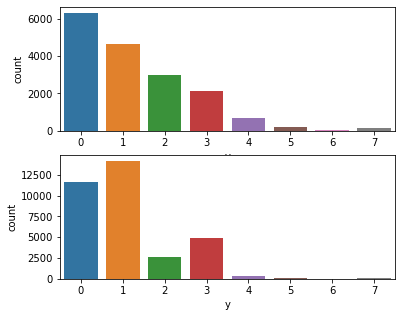

In [20]:
fig = plt.figure(figsize=(6., 5.))
fig.add_subplot(2, 1, 1)
sns.countplot(data=train, x='y')
fig.add_subplot(2, 1, 2)
sns.countplot(data=submission, x='y')
display(train.y.value_counts(normalize=True).sort_index())
display(submission.y.value_counts(normalize=True).sort_index())

In [21]:
submission.to_csv(os.path.join(OUTPUT_DIR, SUB_FILENAME), index=False)

In [22]:
metrics.loc['mean', 'train'], metrics.loc['mean', 'valid']

(0.6909117830268913, 0.15368552603715158)

In [23]:
print('"{}","{}","{:.6f}","{:.6f}","","{}"'.format(SUB_FILENAME, CV, metrics.loc['mean', 'train'], metrics.loc['mean', 'valid'], NOTE))

"087_submission.csv","GroupK-Fold(pitcherID)","0.690912","0.153686","","Decision-function/Predict-probaの取得"


In [24]:
%%time
imp_df = pd.DataFrame()
for i, final_estimator in enumerate(models):
    try:
        if hasattr(final_estimator, 'feature_importances_'):
            feature_importance = final_estimator.feature_importances_
        else:
            feature_importance = final_estimator.final_estimator.get_feature_importance()
            
        if hasattr(final_estimator, 'feature_name_'):
            feature_names = final_estimator.feature_name_
        elif hasattr(final_estimator, 'feature_names_'):
            feature_names = final_estimator.feature_names_
        else:
            feature_names = final_estimator.get_booster().feature_names
        imp_df_ = pd.DataFrame(
            {
                'feature': feature_names,
                'importance': feature_importance
            }
        )
        imp_df_['fold'] = i + 1
        imp_df = pd.concat([imp_df, imp_df_])
    except AttributeError:
        pass

if imp_df.shape[0] > 0:
    imp_df.to_csv(os.path.join(OUTPUT_DIR, 'feature_importances.csv'), index=False)

Wall time: 0 ns


In [25]:
imp_df

""


In [26]:
%%time
coef_df = pd.DataFrame()
for i, final_estimator in enumerate(models):
    try:
        if hasattr(final_estimator, 'coef_'):
            coefficient = final_estimator.coef_
            coef_df_ = pd.DataFrame(coefficient, columns=final_estimator.feature_names__)
            coef_df_['fold'] = i + 1
            coef_df_['y'] = final_estimator.classes_
            coef_df = pd.concat([coef_df, coef_df_])
    except AttributeError:
        pass

if coef_df.shape[0] > 0:
    coef_df.to_csv(os.path.join(OUTPUT_DIR, 'coefficients.csv'), index=False)

Wall time: 28 ms


In [27]:
coef_df

,lgbm0,lgbm1,lgbm2,lgbm3,lgbm4,lgbm5,lgbm6,lgbm7,xgb0,xgb1,...,knn0,knn1,knn2,knn3,knn4,knn5,knn6,knn7,fold,y
0,1.324196,1.492957,0.889401,0.540191,-1.021805,-1.526890,-0.491525,-0.971677,9.418586,0.078061,...,1.939126,-0.204630,0.161135,-0.859921,-0.878486,-0.166151,0.053212,0.190563,1,0
1,0.826942,0.540219,0.729045,1.188064,-0.211289,-1.393984,-0.668125,-0.875735,-0.763212,9.657410,...,0.095877,1.867382,0.294961,-1.322071,-0.467645,-0.228697,-0.185733,0.081063,1,1
2,1.074822,2.135125,0.133581,0.805919,-1.254277,-1.843360,0.327240,-1.251548,-0.702511,-2.618440,...,-0.327129,-0.367152,1.802277,-0.061439,-0.292543,-0.129522,0.007026,-0.504019,1,2
3,1.688961,1.198442,0.401550,0.363716,-0.409357,-1.138255,-0.531743,-1.594549,-2.419730,-1.563086,...,-0.787157,-0.806316,-0.938452,2.900802,-0.060874,-0.290234,-0.019638,-0.019367,1,3
4,-1.255508,-1.516420,0.353199,-1.079578,4.481001,-0.420612,-0.347173,-0.426679,-2.118240,-1.796255,...,-0.189378,0.088473,-0.848143,-1.088324,1.469539,0.382347,0.013766,-0.040051,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3,1.530239,1.075892,-0.047282,0.655793,-0.381532,-0.828733,-0.414167,-1.650456,-2.276504,-2.064118,...,-0.946119,-1.193913,-0.762052,2.754981,0.159179,0.076437,-0.028160,-0.120599,10,3
4,-1.866553,-1.618482,0.405291,-0.876111,4.756009,-0.726659,-0.162894,-0.155807,-1.666192,-1.675031,...,-0.392711,0.143083,-0.909101,-0.718258,1.602148,-0.078253,0.031960,0.075925,10,4
5,-1.468838,-1.420146,-1.197469,-0.718320,-0.880175,5.857034,-0.082398,-0.154365,-1.599267,-1.366344,...,-1.033147,0.355208,-0.110685,0.320872,0.070619,0.328962,-0.001770,0.005265,10,5
6,-0.446483,-0.806099,-0.403568,-0.214778,-0.147456,-0.115505,2.196672,-0.075988,-0.558473,-0.675529,...,0.255295,-0.240499,0.034932,-0.169484,-0.033510,-0.002155,0.144166,-0.001953,10,6


In [28]:
submission_.to_csv(os.path.join(OUTPUT_DIR, 'submission_集計前.csv'), index=False)

In [29]:
submission_

,id,0,1,2,3,4,5,6,7
0,0,0.819457,5.578425,3.357713,0.244383,2.157882e-05,1.479065e-08,1.863097e-10,1.605099e-07
1,1,5.720541,3.546693,0.423448,0.309317,3.598138e-07,4.611904e-08,2.999032e-10,5.287230e-08
2,2,0.131112,0.313633,0.301445,9.250581,3.044975e-03,1.014315e-08,2.657503e-08,1.845510e-04
3,3,3.525217,5.632873,0.762354,0.079555,6.715158e-07,5.371278e-09,7.810772e-10,1.029124e-07
4,4,2.745291,6.355201,0.464672,0.398726,3.611024e-02,3.457776e-08,1.318452e-09,3.632738e-07
...,...,...,...,...,...,...,...,...,...
33803,33803,8.449245,0.605091,0.527278,0.417942,4.427508e-04,2.186659e-08,2.467781e-09,2.942154e-07
33804,33804,5.529505,2.405217,0.475473,1.587440,2.364738e-03,4.958524e-09,3.787382e-10,4.003942e-07
33805,33805,2.195281,4.466306,1.837204,1.501207,2.246288e-07,1.243756e-09,2.434816e-09,1.679963e-06
33806,33806,1.642783,2.277561,5.408487,0.670123,1.045930e-03,3.387614e-08,1.058681e-09,1.641247e-07
